# Install Packages

In [ ]:
# for auditing
!git clone https://github.com/lurosenb/superquail
!pip install aif360==0.3.0 
!pip install BlackBoxAuditing
!pip install tensorflow==1.13.1
!pip install folktables
!pip3 install --upgrade raiwidgets==0.2.0
!pip3 install --upgrade fairlearn==v0.6.0
!pip3 install -U scikit-learn==0.24.1

fatal: destination path 'superquail' already exists and is not an empty directory.


In [ ]:
import pandas as pd
import numpy as np

# from ADS
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

# for ADS auditing
import random
random.seed(6)

import sys
import warnings

import tensorflow as tf
import json
import time 
from tqdm import tqdm

import matplotlib.pyplot as plt 
import seaborn as sns

# to be removed
from folktables import ACSDataSource, ACSEmployment, ACSIncome, ACSPublicCoverage, ACSTravelTime
from superquail.data.acs_helper import ACSData

import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from aif360.datasets import BinaryLabelDataset, StandardDataset
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, RejectOptionClassification
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.metrics import BinaryLabelDatasetMetric

from aif360.explainers import MetricTextExplainer, MetricJSONExplainer
import json
from collections import OrderedDict


import sklearn.metrics as skm
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import selection_rate, false_negative_rate, false_positive_rate

import functools
from aif360.algorithms.inprocessing import PrejudiceRemover
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

import BlackBoxAuditing
%matplotlib inline

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/gdrive/')
%cd /gdrive/MyDrive/"Responsible Data Science"

Drive already mounted at /gdrive/; to attempt to forcibly remount, call drive.mount("/gdrive/", force_remount=True).
/gdrive/MyDrive/Responsible Data Science


In [ ]:
ls

'Alexis Martin, Michael Shu Project'   superquail/       train.csv.zip
 sampleSubmission.csv                  test_v2.csv.zip


In [ ]:
sub = pd.read_csv("sampleSubmission.csv")
train = pd.read_csv("train.csv.zip")
test = pd.read_csv("test_v2.csv.zip")

# Understand ADS Files & Preprocessing Done

In [ ]:
train.shape

(665249, 25)

In [ ]:
train.head()

,customer_ID,shopping_pt,record_type,day,time,state,location,group_size,homeowner,car_age,...,C_previous,duration_previous,A,B,C,D,E,F,G,cost
0,10000000,1,0,0,08:35,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,2,633
1,10000000,2,0,0,08:38,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,1,630
2,10000000,3,0,0,08:38,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,1,630
3,10000000,4,0,0,08:39,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,1,630
4,10000000,5,0,0,11:55,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,1,630


In [ ]:
train['time']

0         08:35
1         08:38
2         08:38
3         08:39
4         11:55
          ...  
665244    13:43
665245    13:43
665246    13:44
665247    13:46
665248    15:14
Name: time, Length: 665249, dtype: object

In [ ]:
test.shape

(198856, 25)

In [ ]:
test.head()

,customer_ID,shopping_pt,record_type,day,time,state,location,group_size,homeowner,car_age,...,C_previous,duration_previous,A,B,C,D,E,F,G,cost
0,10000001,1,0,1,12:35,OK,10002.0,1,0,9,...,3.0,9.0,0,0,1,1,0,0,4,543
1,10000001,2,0,1,12:36,OK,10002.0,1,0,9,...,3.0,9.0,2,1,1,3,1,3,2,611
2,10000002,1,0,4,12:19,PA,10003.0,1,1,7,...,2.0,15.0,2,0,2,3,1,2,2,691
3,10000002,2,0,4,12:21,PA,10003.0,1,1,7,...,2.0,15.0,2,0,2,3,1,2,2,695
4,10000003,1,0,3,17:12,AR,10004.0,1,0,4,...,3.0,1.0,1,0,1,1,0,2,2,628


In [ ]:
sub.shape

(55716, 2)

In [ ]:
sub.head

<bound method NDFrame.head of        customer_ID     plan
0         10000001  1111111
1         10000002  1111111
2         10000003  1111111
3         10000004  1111111
4         10000006  1111111
...            ...      ...
55711     10152712  1111111
55712     10152714  1111111
55713     10152715  1111111
55714     10152719  1111111
55715     10152722  1111111

[55716 rows x 2 columns]>

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 665249 entries, 0 to 665248
Data columns (total 25 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   customer_ID        665249 non-null  int64  
 1   shopping_pt        665249 non-null  int64  
 2   record_type        665249 non-null  int64  
 3   day                665249 non-null  int64  
 4   time               665249 non-null  object 
 5   state              665249 non-null  object 
 6   location           665249 non-null  int64  
 7   group_size         665249 non-null  int64  
 8   homeowner          665249 non-null  int64  
 9   car_age            665249 non-null  int64  
 10  car_value          663718 non-null  object 
 11  risk_factor        424831 non-null  float64
 12  age_oldest         665249 non-null  int64  
 13  age_youngest       665249 non-null  int64  
 14  married_couple     665249 non-null  int64  
 15  C_previous         646538 non-null  float64
 16  du

In [ ]:
train.risk_factor.value_counts()

3.0    117571
4.0    110754
1.0     99476
2.0     97030
Name: risk_factor, dtype: int64

In [ ]:
train.risk_factor = train.risk_factor.fillna(method = 'ffill') 

In [ ]:
train.car_value.nunique()

9

In [ ]:
train.car_value.value_counts()

e    219251
f    177204
d    113174
g     98152
h     28976
c     20820
i      3603
b      1402
a      1136
Name: car_value, dtype: int64

In [ ]:
train.car_value = train.car_value.fillna(method = 'ffill') 

In [ ]:
train.C_previous.value_counts()

3.0    271160
1.0    172007
2.0    109184
4.0     94187
Name: C_previous, dtype: int64

In [ ]:
train.C_previous = train.C_previous.fillna(method = 'ffill') 

In [ ]:
train.duration_previous.value_counts()

1.0     81570
15.0    79849
2.0     79595
3.0     70800
4.0     57485
5.0     49372
6.0     45379
7.0     37768
8.0     30752
9.0     26244
0.0     24926
10.0    18094
11.0    12718
12.0    11284
13.0    10963
14.0     9739
Name: duration_previous, dtype: int64

In [ ]:
train.duration_previous = train.duration_previous.fillna(method = 'ffill') 

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 665249 entries, 0 to 665248
Data columns (total 25 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   customer_ID        665249 non-null  int64  
 1   shopping_pt        665249 non-null  int64  
 2   record_type        665249 non-null  int64  
 3   day                665249 non-null  int64  
 4   time               665249 non-null  object 
 5   state              665249 non-null  object 
 6   location           665249 non-null  int64  
 7   group_size         665249 non-null  int64  
 8   homeowner          665249 non-null  int64  
 9   car_age            665249 non-null  int64  
 10  car_value          665249 non-null  object 
 11  risk_factor        665249 non-null  float64
 12  age_oldest         665249 non-null  int64  
 13  age_youngest       665249 non-null  int64  
 14  married_couple     665249 non-null  int64  
 15  C_previous         665249 non-null  float64
 16  du

In [ ]:
train.describe()

,customer_ID,shopping_pt,record_type,day,location,group_size,homeowner,car_age,risk_factor,age_oldest,...,C_previous,duration_previous,A,B,C,D,E,F,G,cost
count,6.652490e+05,665249.000000,665249.000000,665249.000000,665249.000000,665249.000000,665249.000000,665249.000000,665249.000000,665249.000000,...,665249.000000,665249.000000,665249.000000,665249.000000,665249.000000,665249.000000,665249.000000,665249.000000,665249.000000,665249.000000
mean,1.007655e+07,4.219966,0.145824,1.969429,12271.543022,1.234784,0.536229,8.139437,2.564955,44.992403,...,2.443900,6.004278,0.927546,0.454236,2.275265,2.454299,0.445193,1.162768,2.275120,635.785008
std,4.404978e+04,2.394369,0.352930,1.453470,1564.789415,0.461036,0.498686,5.764598,1.114466,17.403440,...,1.034675,4.681279,0.595221,0.497902,0.990798,0.753953,0.496987,0.943594,0.909567,45.993758
min,1.000000e+07,1.000000,0.000000,0.000000,10001.000000,1.000000,0.000000,0.000000,1.000000,18.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,260.000000
25%,1.003852e+07,2.000000,0.000000,1.000000,10936.000000,1.000000,0.000000,3.000000,2.000000,28.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,2.000000,605.000000
50%,1.007640e+07,4.000000,0.000000,2.000000,12027.000000,1.000000,1.000000,7.000000,3.000000,44.000000,...,3.000000,5.000000,1.000000,0.000000,2.000000,3.000000,0.000000,1.000000,2.000000,635.000000
75%,1.011470e+07,6.000000,0.000000,3.000000,13426.000000,1.000000,1.000000,12.000000,4.000000,60.000000,...,3.000000,9.000000,1.000000,1.000000,3.000000,3.000000,1.000000,2.000000,3.000000,665.000000
max,1.015272e+07,13.000000,1.000000,6.000000,16580.000000,4.000000,1.000000,85.000000,4.000000,75.000000,...,4.000000,15.000000,2.000000,1.000000,4.000000,3.000000,1.000000,3.000000,4.000000,922.000000


In [ ]:
train.head()

,customer_ID,shopping_pt,record_type,day,time,state,location,group_size,homeowner,car_age,...,C_previous,duration_previous,A,B,C,D,E,F,G,cost
0,10000000,1,0,0,08:35,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,2,633
1,10000000,2,0,0,08:38,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,1,630
2,10000000,3,0,0,08:38,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,1,630
3,10000000,4,0,0,08:39,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,1,630
4,10000000,5,0,0,11:55,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,1,630


# Run ADS

In [ ]:
train["plan"] = train.G + train.F * 10 + train.E * 100 + train.D * 1000 + train.C * 10000 + train.B * 100000 + train.A * 1000000

In [ ]:
train.head()

,customer_ID,shopping_pt,record_type,day,time,state,location,group_size,homeowner,car_age,...,duration_previous,A,B,C,D,E,F,G,cost,plan
0,10000000,1,0,0,08:35,IN,10001,2,0,2,...,2.0,1,0,2,2,1,2,2,633,1022122
1,10000000,2,0,0,08:38,IN,10001,2,0,2,...,2.0,1,0,2,2,1,2,1,630,1022121
2,10000000,3,0,0,08:38,IN,10001,2,0,2,...,2.0,1,0,2,2,1,2,1,630,1022121
3,10000000,4,0,0,08:39,IN,10001,2,0,2,...,2.0,1,0,2,2,1,2,1,630,1022121
4,10000000,5,0,0,11:55,IN,10001,2,0,2,...,2.0,1,0,2,2,1,2,1,630,1022121


In [ ]:
test["plan"] = test.G + test.F * 10 + test.E * 100 + test.D * 1000 + test.C * 10000 + test.B * 100000 + test.A * 1000000

In [ ]:
plan_test = test.plan

In [ ]:
test.drop(['plan'],axis=1,inplace=True)

In [ ]:
y_test = test[['A','B','C','C','D','E','F','G']]

In [ ]:
test.drop(['A','B','C','C','D','E','F','G'],axis=1,inplace=True)

In [ ]:
train['hour'] = pd.to_datetime(train.time).dt.hour
train['minute'] = pd.to_datetime(train.time).dt.minute

In [ ]:
train.head()

,customer_ID,shopping_pt,record_type,day,time,state,location,group_size,homeowner,car_age,...,B,C,D,E,F,G,cost,plan,hour,minute
0,10000000,1,0,0,08:35,IN,10001,2,0,2,...,0,2,2,1,2,2,633,1022122,8,35
1,10000000,2,0,0,08:38,IN,10001,2,0,2,...,0,2,2,1,2,1,630,1022121,8,38
2,10000000,3,0,0,08:38,IN,10001,2,0,2,...,0,2,2,1,2,1,630,1022121,8,38
3,10000000,4,0,0,08:39,IN,10001,2,0,2,...,0,2,2,1,2,1,630,1022121,8,39
4,10000000,5,0,0,11:55,IN,10001,2,0,2,...,0,2,2,1,2,1,630,1022121,11,55


In [ ]:
test['hour'] = pd.to_datetime(test.time).dt.hour
test['minute'] = pd.to_datetime(test.time).dt.minute

In [ ]:
test.head()

,customer_ID,shopping_pt,record_type,day,time,state,location,group_size,homeowner,car_age,car_value,risk_factor,age_oldest,age_youngest,married_couple,C_previous,duration_previous,cost,hour,minute
0,10000001,1,0,1,12:35,OK,10002.0,1,0,9,f,NaN,24,24,0,3.0,9.0,543,12,35
1,10000001,2,0,1,12:36,OK,10002.0,1,0,9,f,NaN,24,24,0,3.0,9.0,611,12,36
2,10000002,1,0,4,12:19,PA,10003.0,1,1,7,f,NaN,74,74,0,2.0,15.0,691,12,19
3,10000002,2,0,4,12:21,PA,10003.0,1,1,7,f,NaN,74,74,0,2.0,15.0,695,12,21
4,10000003,1,0,3,17:12,AR,10004.0,1,0,4,d,4.0,26,26,0,3.0,1.0,628,17,12


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198856 entries, 0 to 198855
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   customer_ID        198856 non-null  int64  
 1   shopping_pt        198856 non-null  int64  
 2   record_type        198856 non-null  int64  
 3   day                198856 non-null  int64  
 4   time               198856 non-null  object 
 5   state              198856 non-null  object 
 6   location           198178 non-null  float64
 7   group_size         198856 non-null  int64  
 8   homeowner          198856 non-null  int64  
 9   car_age            198856 non-null  int64  
 10  car_value          198117 non-null  object 
 11  risk_factor        123369 non-null  float64
 12  age_oldest         198856 non-null  int64  
 13  age_youngest       198856 non-null  int64  
 14  married_couple     198856 non-null  int64  
 15  C_previous         189087 non-null  float64
 16  du

In [ ]:
test.duration_previous = test.duration_previous.fillna(method = 'ffill') 
test.C_previous = test.C_previous.fillna(method = 'ffill') 
test.risk_factor = test.risk_factor.fillna(method = 'ffill') 
test.car_value = test.car_value.fillna(method = 'ffill') 

In [ ]:
columns_to_Encode = ['state','car_value']
le = LabelEncoder()
for each in columns_to_Encode:
    train[each] = le.fit_transform(train[each])
for column in columns_to_Encode:
  test[column] = le.fit_transform(test[column])

In [ ]:
train.drop(['time'],axis=1,inplace=True)
test.drop(['time'],axis=1,inplace=True)

In [ ]:
train.columns

Index(['customer_ID', 'shopping_pt', 'record_type', 'day', 'state', 'location',
       'group_size', 'homeowner', 'car_age', 'car_value', 'risk_factor',
       'age_oldest', 'age_youngest', 'married_couple', 'C_previous',
       'duration_previous', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'cost', 'plan',
       'hour', 'minute'],
      dtype='object')

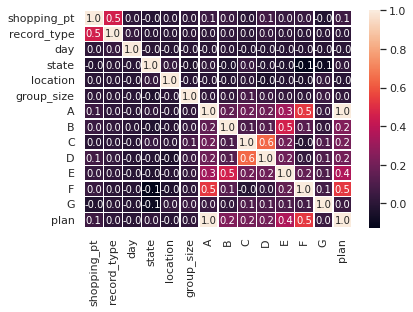

In [ ]:
df = train[['shopping_pt', 'record_type', 'day', 'state', 'location', 'group_size','A', 'B', 'C', 'D', 'E', 'F', 'G','plan']]
sns.heatmap(df.corr(), annot=True, fmt=".1f", linewidths=.5)

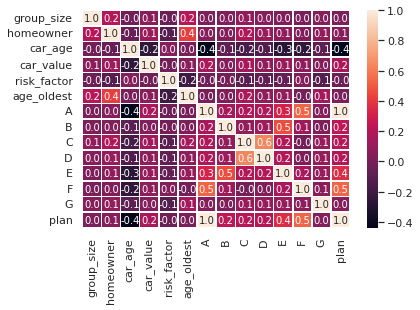

In [ ]:
df1 = train[['group_size',
       'homeowner', 'car_age', 'car_value', 'risk_factor', 'age_oldest','A', 'B', 'C', 'D', 'E', 'F', 'G','plan']]
sns.heatmap(df1.corr(), annot=True, fmt=".1f", linewidths=.5)

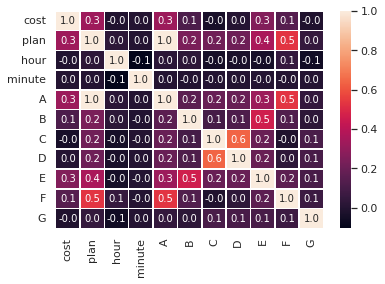

In [ ]:
df3 = train[['cost', 'plan', 'hour', 'minute','A', 'B', 'C', 'D', 'E', 'F', 'G']]
sns.heatmap(df3.corr(), annot=True, fmt=".1f", linewidths=.5)

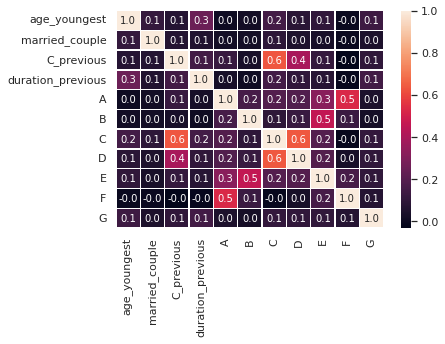

In [ ]:
df2 = train[['age_youngest', 'married_couple', 'C_previous', 'duration_previous','A', 'B', 'C', 'D', 'E', 'F', 'G']]
sns.heatmap(df2.corr(), annot=True, fmt=".1f", linewidths=.5)

In [ ]:
train.head()

,customer_ID,shopping_pt,record_type,day,state,location,group_size,homeowner,car_age,car_value,...,B,C,D,E,F,G,cost,plan,hour,minute
0,10000000,1,0,0,10,10001,2,0,2,6,...,0,2,2,1,2,2,633,1022122,8,35
1,10000000,2,0,0,10,10001,2,0,2,6,...,0,2,2,1,2,1,630,1022121,8,38
2,10000000,3,0,0,10,10001,2,0,2,6,...,0,2,2,1,2,1,630,1022121,8,38
3,10000000,4,0,0,10,10001,2,0,2,6,...,0,2,2,1,2,1,630,1022121,8,39
4,10000000,5,0,0,10,10001,2,0,2,6,...,0,2,2,1,2,1,630,1022121,11,55


In [ ]:
train.location.nunique()

6248

In [ ]:
plan_train = train.plan

In [ ]:
train.drop(['plan'],axis=1,inplace=True)

In [ ]:
y_train = train[['A','B','C','D','E','F','G']]
train.drop(['A','B','C','D','E','F','G'],axis=1,inplace=True)
test.head()

,customer_ID,shopping_pt,record_type,day,state,location,group_size,homeowner,car_age,car_value,risk_factor,age_oldest,age_youngest,married_couple,C_previous,duration_previous,cost,hour,minute
0,10000001,1,0,1,25,10002.0,1,0,9,5,NaN,24,24,0,3.0,9.0,543,12,35
1,10000001,2,0,1,25,10002.0,1,0,9,5,NaN,24,24,0,3.0,9.0,611,12,36
2,10000002,1,0,4,27,10003.0,1,1,7,5,NaN,74,74,0,2.0,15.0,691,12,19
3,10000002,2,0,4,27,10003.0,1,1,7,5,NaN,74,74,0,2.0,15.0,695,12,21
4,10000003,1,0,3,1,10004.0,1,0,4,3,4.0,26,26,0,3.0,1.0,628,17,12


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198856 entries, 0 to 198855
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   customer_ID        198856 non-null  int64  
 1   shopping_pt        198856 non-null  int64  
 2   record_type        198856 non-null  int64  
 3   day                198856 non-null  int64  
 4   state              198856 non-null  int64  
 5   location           198178 non-null  float64
 6   group_size         198856 non-null  int64  
 7   homeowner          198856 non-null  int64  
 8   car_age            198856 non-null  int64  
 9   car_value          198856 non-null  int64  
 10  risk_factor        198852 non-null  float64
 11  age_oldest         198856 non-null  int64  
 12  age_youngest       198856 non-null  int64  
 13  married_couple     198856 non-null  int64  
 14  C_previous         198856 non-null  float64
 15  duration_previous  198856 non-null  float64
 16  co

In [ ]:
test_id = test.customer_ID
test.drop(['customer_ID'],axis=1,inplace=True)
train.head(2)

,customer_ID,shopping_pt,record_type,day,state,location,group_size,homeowner,car_age,car_value,risk_factor,age_oldest,age_youngest,married_couple,C_previous,duration_previous,cost,hour,minute
0,10000000,1,0,0,10,10001,2,0,2,6,3.0,46,42,1,1.0,2.0,633,8,35
1,10000000,2,0,0,10,10001,2,0,2,6,3.0,46,42,1,1.0,2.0,630,8,38


In [ ]:
y_train.head(2)

,A,B,C,D,E,F,G
0,1,0,2,2,1,2,2
1,1,0,2,2,1,2,1


In [ ]:
train.drop(['customer_ID'],axis=1,inplace=True)

In [ ]:
test.head(2)

,shopping_pt,record_type,day,state,location,group_size,homeowner,car_age,car_value,risk_factor,age_oldest,age_youngest,married_couple,C_previous,duration_previous,cost,hour,minute
0,1,0,1,25,10002.0,1,0,9,5,NaN,24,24,0,3.0,9.0,543,12,35
1,2,0,1,25,10002.0,1,0,9,5,NaN,24,24,0,3.0,9.0,611,12,36


In [ ]:
train.shape

(665249, 18)

In [ ]:
test.shape

(198856, 18)

In [ ]:
rfc = RandomForestClassifier(n_estimators=100,criterion='entropy',random_state=42,max_depth =5) # changed from 600 to 100 for runtime, as well as max_depth to five
#otherwise it takes too much ram and crashes
rfc.fit(train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, random_state=42)

# Audit ADS

In [ ]:
x=train.copy()

def cat1(value):
    if value < 3:
        return '< 3'
    elif value > 3 and value <=5:
        return "3-5"
    elif value > 5 and value <=10:
        return "5-10"
    elif value > 10 and value <=15:
        return "10-15"
    elif value > 15 and value <=25:
        return "15-25"
    elif value > 25 and value <=35:
        return "25-35"
    else:
        return ">35"
x['car_age'] = x.apply(lambda row: cat1(row['car_age']), axis = 1)


def cat2(value):
    if value < 21:
        return '< 21'
    elif value > 21 and value <=25:
        return "21-25"
    elif value > 25 and value <=30:
        return "25-30"
    elif value > 30 and value <=45:
        return "30-45"
    elif value > 45 and value <=55:
        return "45-55"
    elif value > 55 and value <=65:
        return "55-65"
    else:
        return ">65"
x['age_youngest'] = x.apply(lambda row: cat2(row['age_youngest']), axis = 1)

x['age_oldest'] = x.apply(lambda row: cat2(row['age_oldest']), axis = 1)


In [ ]:
x['married_couple'] = x['married_couple'].map({0: 'single', 1: 'married'})

x['homeowner'] = x['homeowner'].map({0: 'rent', 1: 'own'})

x['risk_factor'] = x['risk_factor'].map({1.: "low", 2.: "mid",3.:"mid-high",4.:"high"})


In [ ]:
print("All Customers")
pd.crosstab(x["married_couple"], x["risk_factor"])

All Customers


risk_factor,high,low,mid,mid-high
married_couple,,,,
married,32696,38174,34189,34498
single,141536,118972,115164,150020


In [ ]:
print("All Customers")
pd.crosstab(x["age_youngest"], x["risk_factor"])

All Customers


risk_factor,high,low,mid,mid-high
age_youngest,,,,
21-25,27614,16637,20708,28683
25-30,27988,14974,18021,22321
30-45,46845,30791,33755,45022
45-55,26396,21779,22260,26603
55-65,19993,26125,21730,22029
< 21,8592,5762,6309,15537
>65,16804,41078,26570,24323


In [ ]:
print("All Customers")
pd.crosstab(x["married_couple"], x["risk_factor"])

In [ ]:
print(test['risk_factor'].isna().sum())
test.head()

4


,shopping_pt,record_type,day,state,location,group_size,homeowner,car_age,car_value,risk_factor,age_oldest,age_youngest,married_couple,C_previous,duration_previous,cost,hour,minute
0,1,0,1,25,10002.0,1,0,9,5,NaN,24,24,0,3.0,9.0,543,12,35
1,2,0,1,25,10002.0,1,0,9,5,NaN,24,24,0,3.0,9.0,611,12,36
2,1,0,4,27,10003.0,1,1,7,5,NaN,74,74,0,2.0,15.0,691,12,19
3,2,0,4,27,10003.0,1,1,7,5,NaN,74,74,0,2.0,15.0,695,12,21
4,1,0,3,1,10004.0,1,0,4,3,4.0,26,26,0,3.0,1.0,628,17,12


In [ ]:
test['risk_factor'].fillna(method = 'bfill',inplace = True)
'''There are 4 random NaNs at the beginning of the test in the risk_factor column, which isn't allowed when trying to run predictions. 
The ADS simply didn't create any predictions. So, we will be assigning them all the value of 4 by using backfill. '''

"There are 4 random NaNs at the beginning of the test in the risk_factor column, which isn't allowed when trying to run predictions. \nThe ADS simply didn't create any predictions. So, we will be assigning them all the value of 4 by using backfill. "

In [ ]:
print(test.isna().sum())

shopping_pt            0
record_type            0
day                    0
state                  0
location             678
group_size             0
homeowner              0
car_age                0
car_value              0
risk_factor            0
age_oldest             0
age_youngest           0
married_couple         0
C_previous             0
duration_previous      0
cost                   0
hour                   0
minute                 0
dtype: int64


In [ ]:
print(test['location'].mode())

0    11179.0
dtype: float64


In [ ]:
test['location'].fillna(test['location'].mode().iloc[0],inplace = True)
'''There are also a significant amount of nans in location(678), so we we will fill those with the mode of the location'''

'There are also a significant amount of nans in location(678), so we we will fill those with the mode of the location'

In [ ]:
predictions = rfc.predict(test)

In [ ]:
print(len(y_test))
print(type(y_test))
print(len(predictions))
print(type(predictions))

198856
<class 'pandas.core.frame.DataFrame'>
198856
<class 'numpy.ndarray'>


In [ ]:
temp = y_test.to_numpy()

In [ ]:
print(y_test)
print(temp.shape)
print(predictions.shape)

        A  B  C  C  D  E  F  G
0       0  0  1  1  1  0  0  4
1       2  1  1  1  3  1  3  2
2       2  0  2  2  3  1  2  2
3       2  0  2  2  3  1  2  2
4       1  0  1  1  1  0  2  2
...    .. .. .. .. .. .. .. ..
198851  1  0  4  4  3  1  0  2
198852  1  0  4  4  3  1  0  2
198853  1  1  3  3  3  1  1  3
198854  1  1  3  3  3  1  1  3
198855  0  1  3  3  3  0  0  3

[198856 rows x 8 columns]
(198856, 8)
(198856, 7)


In [ ]:
skm.accuracy_score(temp[:,2],temp[:,3])

1.0

In [ ]:
'''for some reason there are duplicate columns of C. We're going to remove one of them from data since they're literally identical'''
test_values = np.delete(temp,2,axis=1)

In [ ]:
'''Running skm accuracy score on the entire matrix of test values and predictions returned an error of 
"multiclass-multioutput is not supported". So, we decided to look at the models accuracy when predicting each insurance plan indivudally,
rather than all of them at once. We measured overall accuracy as the means of all of these individual accuracies. It comes out to 60%'''
print(skm.accuracy_score(test_values[:,0],predictions[:,0]))
print(skm.accuracy_score(test_values[:,1],predictions[:,1]))
print(skm.accuracy_score(test_values[:,2],predictions[:,2]))
print(skm.accuracy_score(test_values[:,3],predictions[:,3]))
print(skm.accuracy_score(test_values[:,4],predictions[:,4]))
print(skm.accuracy_score(test_values[:,5],predictions[:,5]))
print(skm.accuracy_score(test_values[:,6],predictions[:,6]))

0.7084774912499497
0.5708452347427284
0.6211127650158909
0.5874049563503239
0.6467946654865833
0.5522287484410829
0.5121344088184415


In [ ]:
(0.7084774912499497 + 0.570870378565394 + 0.6211127650158909 + 0.5874049563503239 + 0.6467946654865833 + 0.5522237196765498 + 0.5121344088184415)/7

0.599859769309019

Text(0.5, 0.98, 'Counts for what type of plan was purchased for each insurance option from A to G')

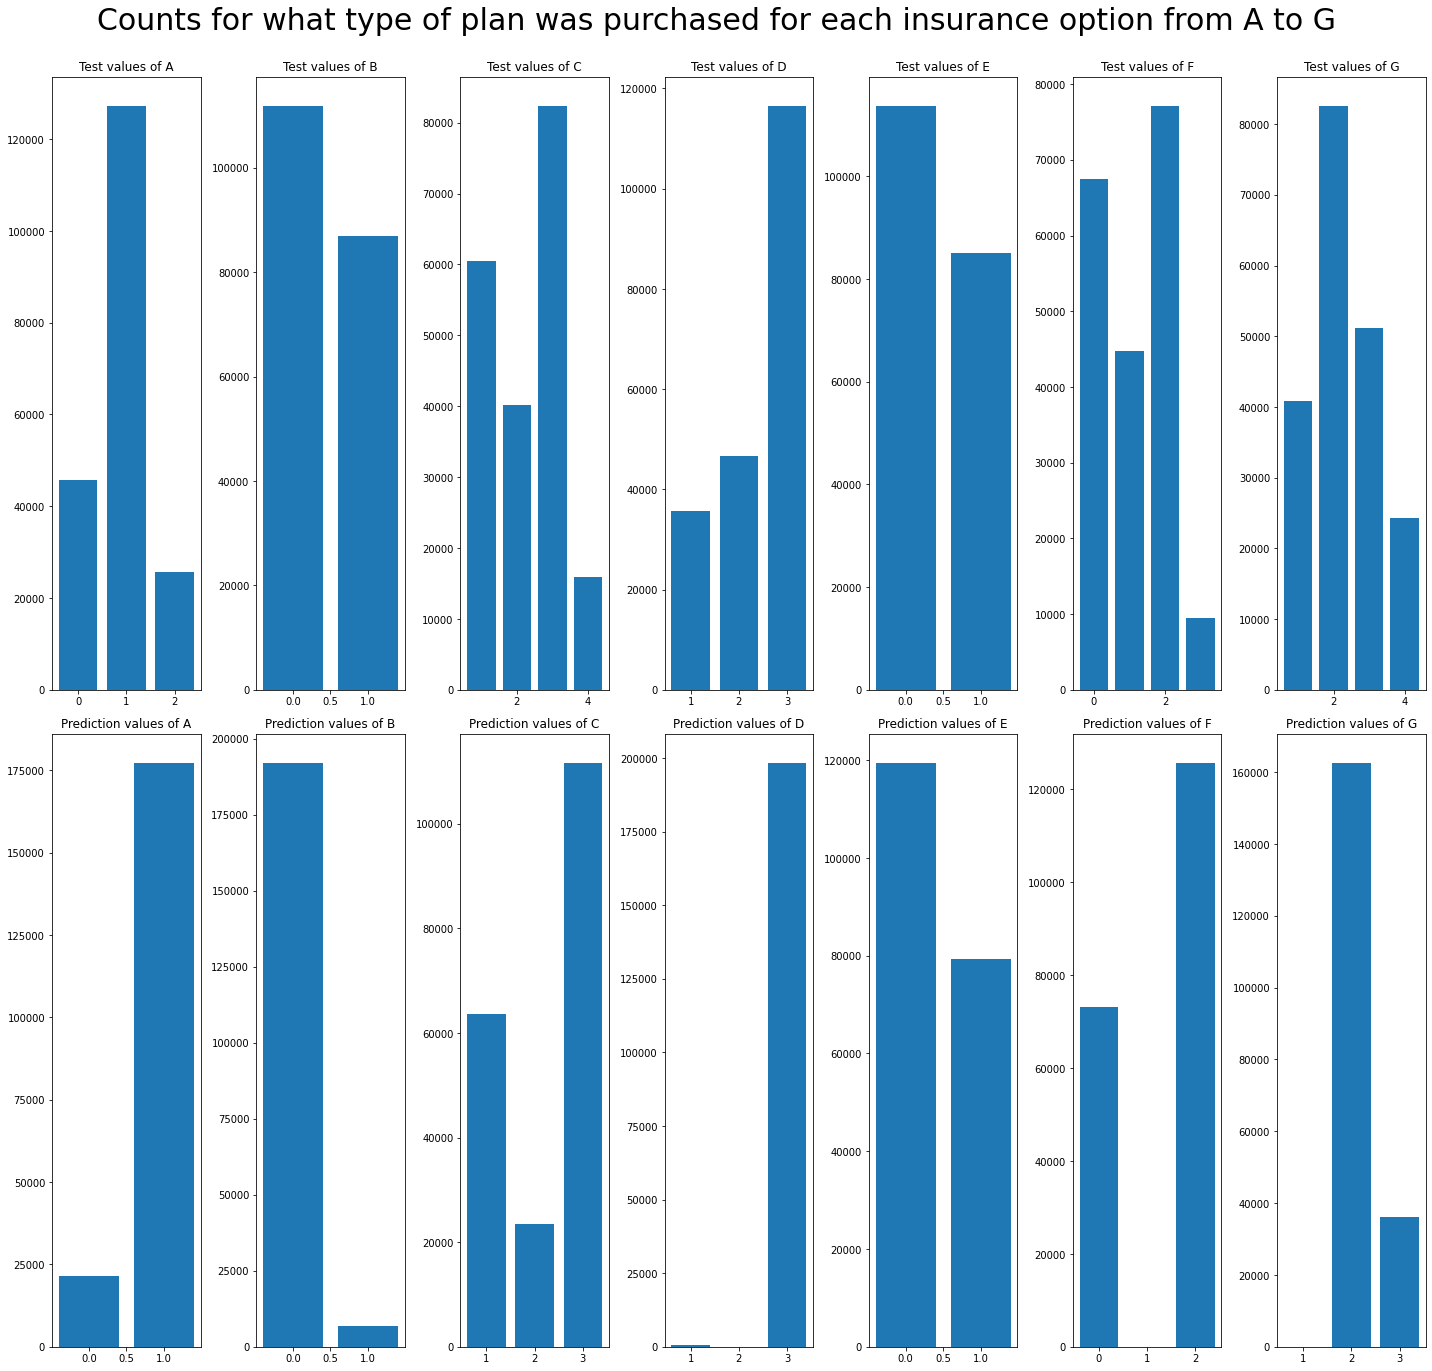

In [ ]:
fig,axes = plt.subplots(nrows = 2, ncols = 7,figsize = (20,20))
test_transpose = test_values.transpose()
predictions_transpose = predictions.transpose()
titles = ['A','B','C','D','E','F','G']
i = 0
for x in test_transpose:
  u,c = np.unique(x,return_counts = True)
  axes[0,i].bar(x = u,height = c)
  axes[0,i].set_title('Test values of ' + titles[i])
  i+=1
i = 0
for y in predictions_transpose:
  u,c = np.unique(y,return_counts = True)
  axes[1,i].bar(x = u,height = c)
  axes[1,i].set_title('Prediction values of ' + titles[i])
  i+=1
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Counts for what type of plan was purchased for each insurance option from A to G',fontsize = 30)


In [ ]:
age = test.copy()

In [ ]:
a2 = []
for x in range(len(test_values)):
  if(test_values[x,0]==2):
    a2.append(x)
a2_data = age.iloc[a2]
age = age.drop(a2)

In [ ]:
print(type(a2_data))
len(a2_data)

<class 'pandas.core.frame.DataFrame'>


25770

In [ ]:
olda2Total = a2_data['age_oldest'].sum()
younga2Total = a2_data['age_youngest'].sum()
totala2 = olda2Total - younga2Total
print(totala2/len(a2_data))#On average a 2 year difference between oldest and youngest. Lots of 0 counts

2.3227008149010477


In [ ]:
oldTotal = age['age_oldest'].sum()
youngTotal = age['age_youngest'].sum()
total = oldTotal - youngTotal
print(total/len(age))

2.2518979004656643


In [ ]:
soloPlana2 = a2_data[a2_data['age_oldest']-a2_data['age_youngest']==0]
soloPlan = age[age['age_oldest']-age['age_youngest']==0]
print(len(soloPlana2)/len(a2_data))
print(len(soloPlan)/len(age))

0.7733410942956926
0.7821545358954508


In [ ]:
import xgboost
from xgboost import plot_importance

In [ ]:
gbtree = xgboost.XGBClassifier(n_estimators=100, max_depth=5)
gbtree.fit(train,y_train['A'])

XGBClassifier(max_depth=5, objective='multi:softprob')

In [ ]:
pred_labels_test = gbtree.predict(test)

In [ ]:
u,c = np.unique(pred_labels_test,return_counts = True)
print(u)
print(c)

[0 1 2]
[ 37184 160300   1372]


Text(0.5, 0.98, 'Counts for what type of plan was purchased for insurance option A, using xgboost tree')

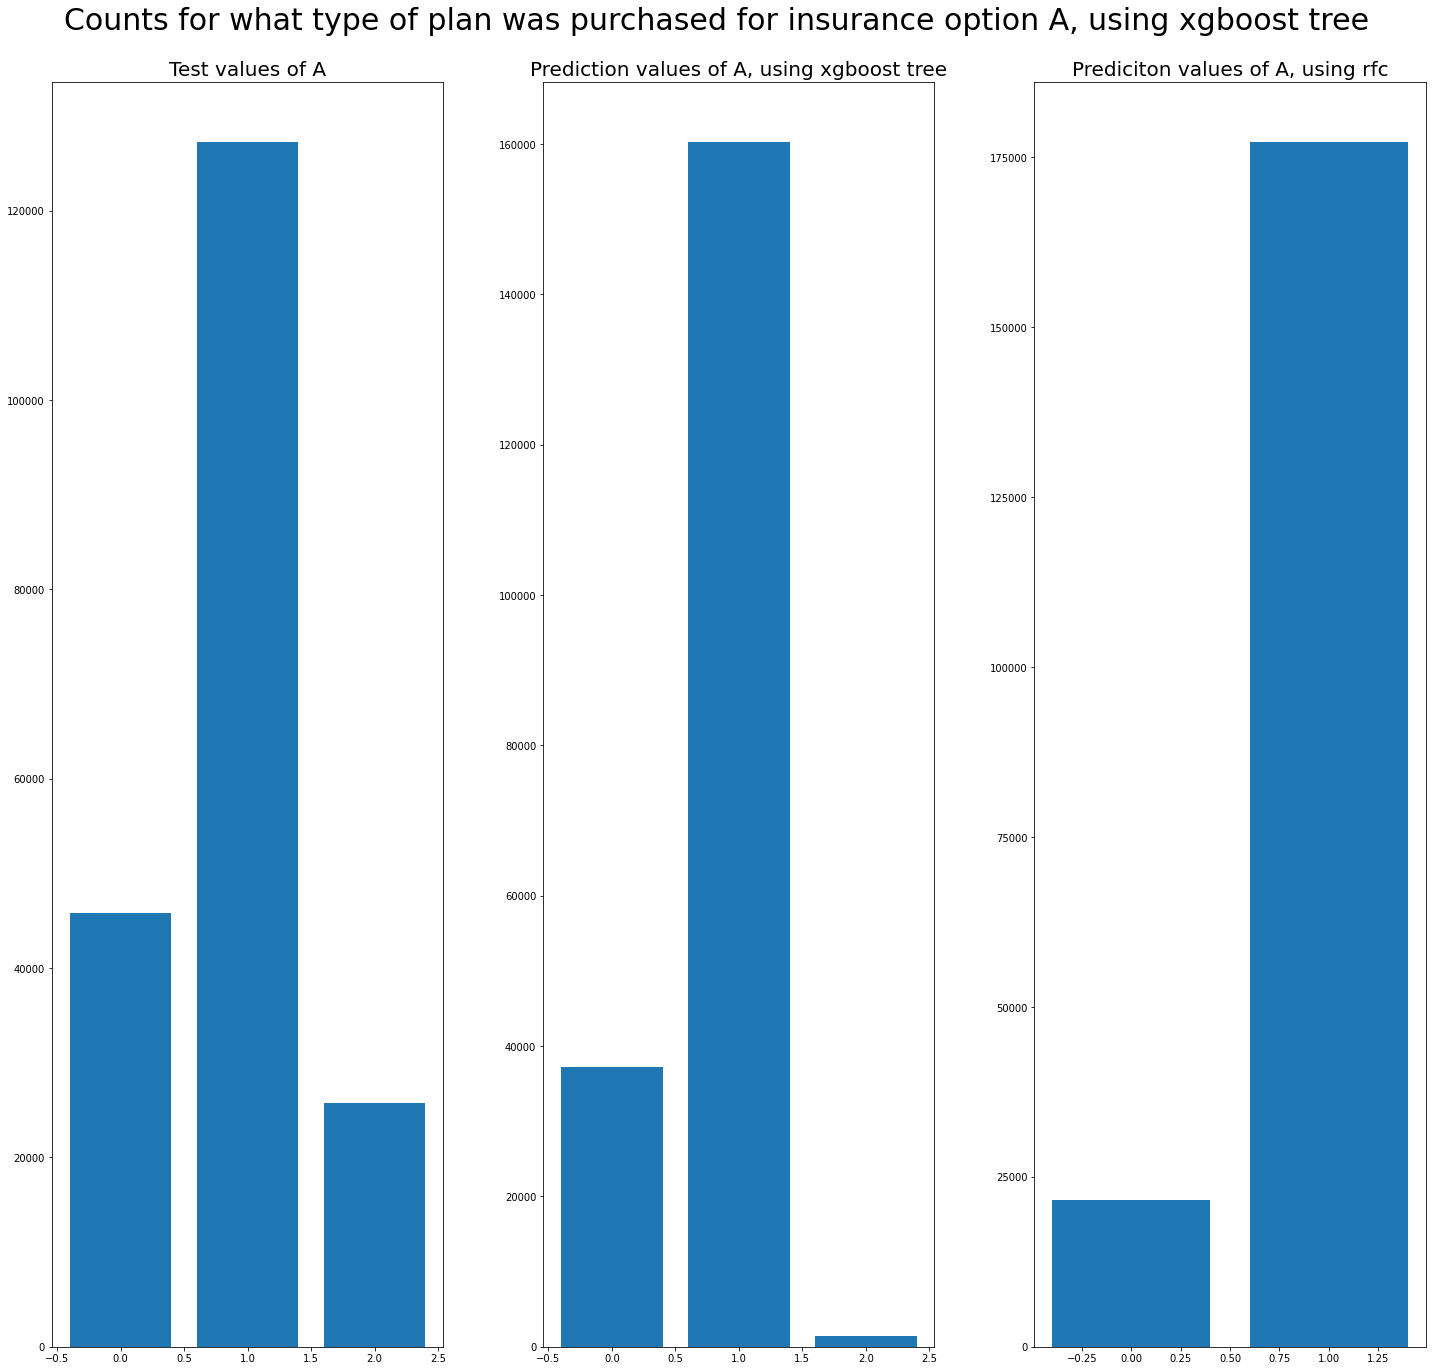

In [ ]:
fig2,axes2 = plt.subplots(nrows = 1, ncols = 3,figsize = (20,20))

u,c = np.unique(test_values[:,0],return_counts = True)
axes2[0].bar(x = u,height = c)
axes2[0].set_title('Test values of A',fontsize = 20)


u,c = np.unique(pred_labels_test,return_counts = True)
axes2[1].bar(x = u,height = c)
axes2[1].set_title('Prediction values of A, using xgboost tree',fontsize = 20)

u,c = np.unique(predictions[:,0],return_counts = True)
axes2[2].bar(x = u, height = c)
axes2[2].set_title('Prediciton values of A, using rfc',fontsize = 20)

fig2.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Counts for what type of plan was purchased for insurance option A, using xgboost tree',fontsize = 30)

In [ ]:
#xgb tree has a similar thing that happens to the values of 2 in the insurance plan A as the rfc of the adt. Dunno why this is

In [ ]:
plot_importance(gbtree.get_booster(),importance_type = "weight")
plt.rcParams["figure.figsize"] = (20,20)
#plt.set_title('Feature Importance using importance_type = "gain" ')
#importance_type = weight, gain or cover
'''
How the importance is calculated: either “weight”, “gain”, or “cover”

”weight” is the number of times a feature appears in a tree

”gain” is the average gain of splits which use the feature

”cover” is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split
'''
#when we set the importance type to weight, it looks like state actually has the largest affect. Maybe there is some discrimination based upon what state a user lives in?

In [ ]:
print(np.sort(a2_data['state'].unique()))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]


In [ ]:
plt.hist(a2_data['state'],bins = np.sort(a2_data['state'].unique()))
plt.xlabel('State ID',fontsize = 20)
plt.ylabel('Counts of state',fontsize = 20)
plt.title('Counts of state within the data of people that chose 2 on their A insurance plan',fontsize = 20)

In [ ]:
plt.hist(age['state'],bins = np.sort(age['state'].unique()))
plt.xlabel('State ID',fontsize = 20)
plt.ylabel('Counts of state',fontsize = 20)
plt.title('Counts of state within the data of people that did not choose 2 on their A insurance plan',fontsize = 20)

In [ ]:
u,c = np.unique(a2_data['state'],return_counts = True)
array = np.stack((u, c),axis = 1)
result = array.astype(int)
np.set_printoptions(threshold=np.inf)
print(result[(-result[:,1]).argsort()])

In [ ]:
u,c = np.unique(age['state'],return_counts = True)
array = np.stack((u, c),axis = 1)
result = array.astype(int)
np.set_printoptions(threshold=np.inf)
print(result[(-result[:,1]).argsort()])

In [ ]:
test = train.copy()

In [ ]:
print(test['age_oldest'])

0         46
1         46
2         46
3         46
4         46
          ..
665244    20
665245    20
665246    20
665247    20
665248    20
Name: age_oldest, Length: 665249, dtype: int64


In [ ]:
print(test['age_youngest'])

0         42
1         42
2         42
3         42
4         42
          ..
665244    20
665245    20
665246    20
665247    20
665248    20
Name: age_youngest, Length: 665249, dtype: int64


In [ ]:
test['age_difference'] = test['age_oldest'] - test['age_youngest']

In [ ]:
print(test['age_difference'])

0          4
1          4
2          4
3          4
4          4
          ..
665170    32
665171    32
665172    32
665173    32
665174    32
Name: age_difference, Length: 149933, dtype: int64


In [ ]:
test = test[test['age_difference']!=0]

In [ ]:
test2 = train.copy()
cond = test['customer_ID'].isin(test2['customer_ID'])
test2.drop(test[cond].index, inplace = True)


In [ ]:
print(len(test))
len(test2)

149933


515316

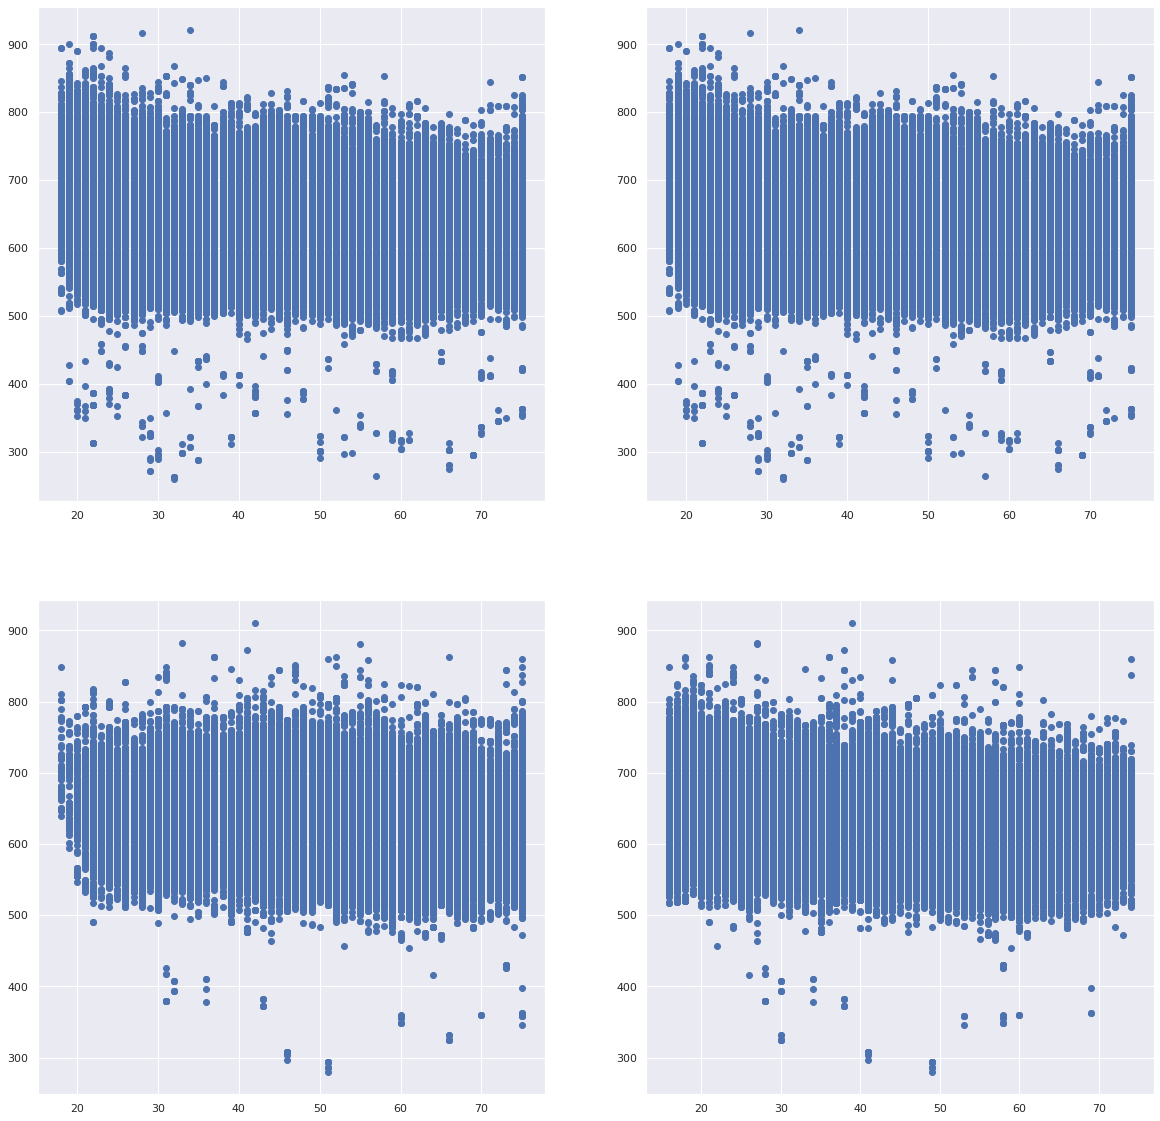

In [ ]:
fig, ax = plt.subplots(2,2)

ax[0,0].scatter(x = test2['age_oldest'],y = test2['cost'])
ax[0,1].scatter(x = test2['age_youngest'],y = test2['cost'])
ax[1,0].scatter(x = test['age_oldest'],y = test['cost'])
ax[1,1].scatter(x = test['age_youngest'],y = test['cost'])